In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import lightgbm as lgb
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

import os
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import gc
import re
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from textblob import TextBlob
from tqdm import tqdm

In [2]:
df_train = pd.read_csv("drugsComTrain_raw.csv")
df_test = pd.read_csv("drugsComTest_raw.csv") 

In [3]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
df_train.shape,df_test.shape

((161297, 7), (53766, 7))

In [6]:
df_train.dtypes,df_test.dtypes

(uniqueID        int64
 drugName       object
 condition      object
 review         object
 rating          int64
 date           object
 usefulCount     int64
 dtype: object,
 uniqueID        int64
 drugName       object
 condition      object
 review         object
 rating          int64
 date           object
 usefulCount     int64
 dtype: object)

In [7]:
df_train.describe()

,uniqueID,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [8]:
df_test.describe()

,uniqueID,rating,usefulCount
count,53766.000000,53766.000000,53766.000000
mean,116386.701187,6.976900,27.989752
std,67017.739881,3.285207,36.172833
min,0.000000,1.000000,0.000000
25%,58272.500000,4.000000,6.000000
50%,116248.500000,8.000000,16.000000
75%,174586.750000,10.000000,36.000000
max,232284.000000,10.000000,949.000000


In [9]:
df_train.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [10]:
df_test.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [11]:
df_train.isnull().sum(axis = 0)

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [12]:
df_train.isnull().sum(axis = 0)['condition']/df_train.shape[0]

0.005573569254232875

In [13]:
df_test.isnull().sum(axis = 0)

uniqueID         0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [14]:
df_test.isnull().sum(axis = 0)['condition']/df_test.shape[0]

0.0054867388312316336

In [15]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

In [16]:
df_train.isnull().any().any(), df_test.isnull().any().any()

(False, False)

In [17]:
df_train.condition.unique().size, df_test.condition.unique().size

(884, 708)

In [18]:
df_train.drugName.unique().size, df_test.drugName.unique().size

(3431, 2635)

In [19]:
conditions = df_train.condition.value_counts().sort_values(ascending=False)
conditions[:10]

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

In [20]:
plt.rcParams['figure.figsize'] = [12, 8]

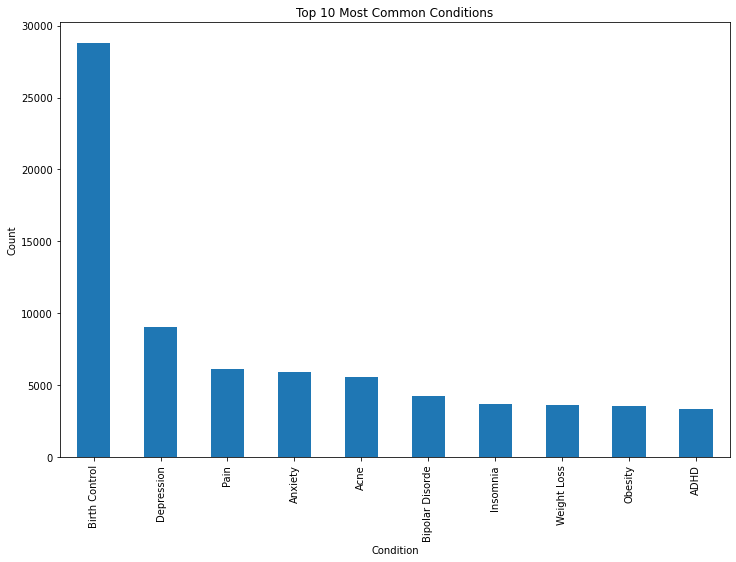

In [21]:
conditions[:10].plot(kind='bar')
plt.title('Top 10 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');

In [22]:
df_train.corr()

,uniqueID,rating,usefulCount
uniqueID,1.000000,0.014896,0.015945
rating,0.014896,1.000000,0.234379
usefulCount,0.015945,0.234379,1.000000


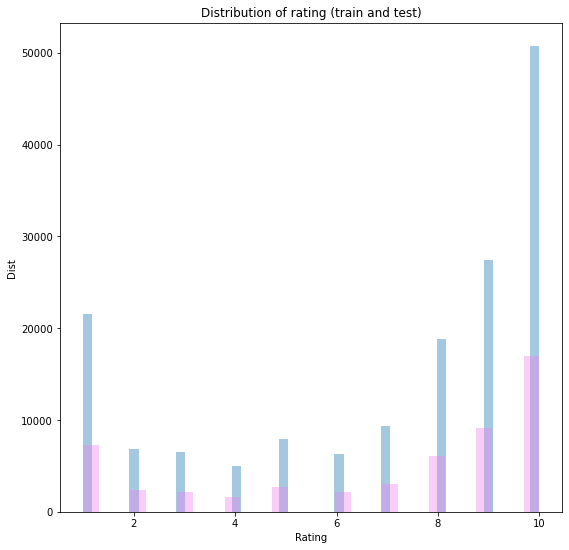

In [23]:
plt.figure(figsize=(9,9))

sns.distplot(df_train['rating'],kde=False)
sns.distplot(df_test['rating'],color='violet',kde=False)

plt.xlabel('Rating')
plt.ylabel('Dist')
plt.title("Distribution of rating (train and test)")

plt.show()

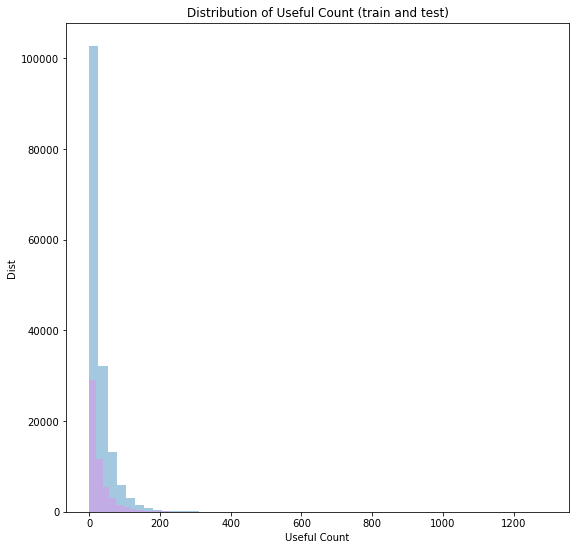

In [24]:
plt.figure(figsize=(9,9))

sns.distplot(df_train['usefulCount'],kde=False)
sns.distplot(df_test['usefulCount'],color='violet',kde=False)

plt.xlabel('Useful Count')
plt.ylabel('Dist')
plt.title("Distribution of Useful Count (train and test)")

plt.show()

Text(0, 0.5, 'Useful Count')

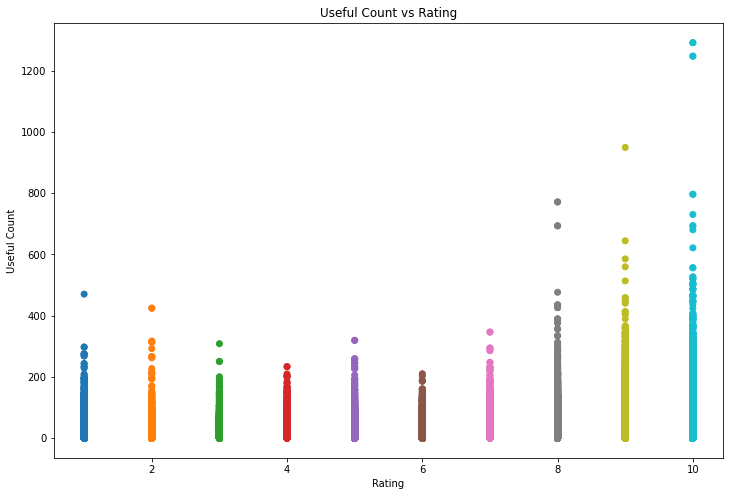

In [25]:
plt.scatter(df_train.rating, df_train.usefulCount, c=df_train.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')

Text(0.5, 1.0, 'Total Missing Value ')

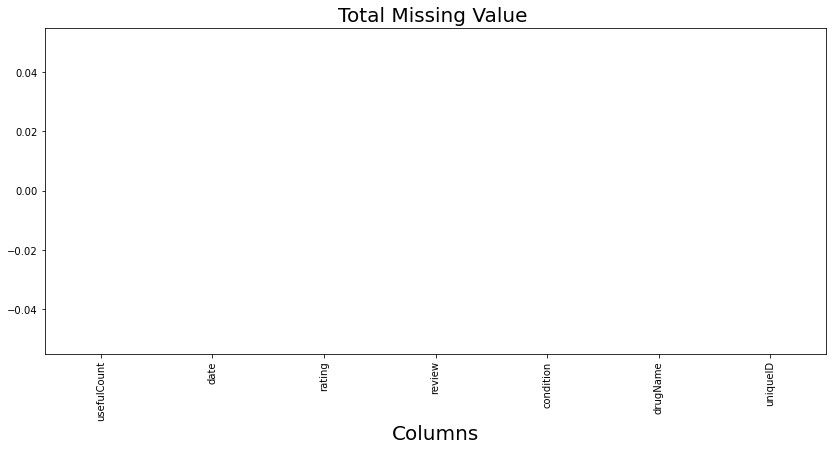

In [26]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [27]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)

,uniqueID,drugName,condition,review,rating,date,usefulCount
241,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,1-Jun-10,3
1853,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1,16-Dec-15,3
3305,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9,12-Dec-15,3


In [28]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)
print(span_list[:100])

[104, 194, 241, 262, 389, 513, 550, 568, 675, 682, 923, 1249, 1506, 1798, 1853, 1871, 2190, 2448, 2752, 2858, 2860, 3204, 3220, 3305, 3697, 3811, 4221, 4298, 4739, 4843, 4903, 4915, 5116, 5214, 5422, 5423, 5528, 5681, 6035, 6041, 6123, 6264, 6299, 6317, 6327, 6543, 6610, 6923, 6996, 7372, 7510, 7700, 7775, 7778, 7871, 8047, 8088, 8313, 8410, 9255, 9338, 9339, 9346, 9578, 9619, 9673, 9685, 9741, 10048, 10138, 10295, 10395, 10544, 10579, 10595, 10613, 10916, 11196, 11380, 11735, 11999, 12255, 12262, 12313, 12346, 12378, 12631, 13056, 13112, 13403, 13813, 13872, 14025, 14276, 14528, 14564, 14639, 15305, 15551, 15697]


In [29]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [30]:
df_all[df_all['condition']=='3</span> users found this comment helpful.']

,uniqueID,drugName,condition,review,rating,date,usefulCount


In [31]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Hemangioma,1
817,Q Feve,1
818,Urinary Retention,1
819,Diagnostic Bronchograms,1
820,Steroid Responsive Inflammatory Conditions,1
821,Cluster-Tic Syndrome,1
822,Nausea (phosphorated carbohydrate solution),1
823,Ramsay Hunt Syndrome,1
824,Rat-bite Feve,1
825,Hemorrhoids (pramoxine / zinc oxide),1


In [32]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0                           Uveitis, Posteri
1                    Pseudogout, Prophylaxis
2                        Infectious Diarrhea
3                   Thyroid Suppression Test
4                                 Angioedema
5                                Scleroderma
6                                        mis
7            Anti NMDA Receptor Encephalitis
8                                     mist (
9    Pruritus of Partial Biliary Obstruction
Name: condition, dtype: object

In [33]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [34]:
stops = set(stopwords.words('english'))

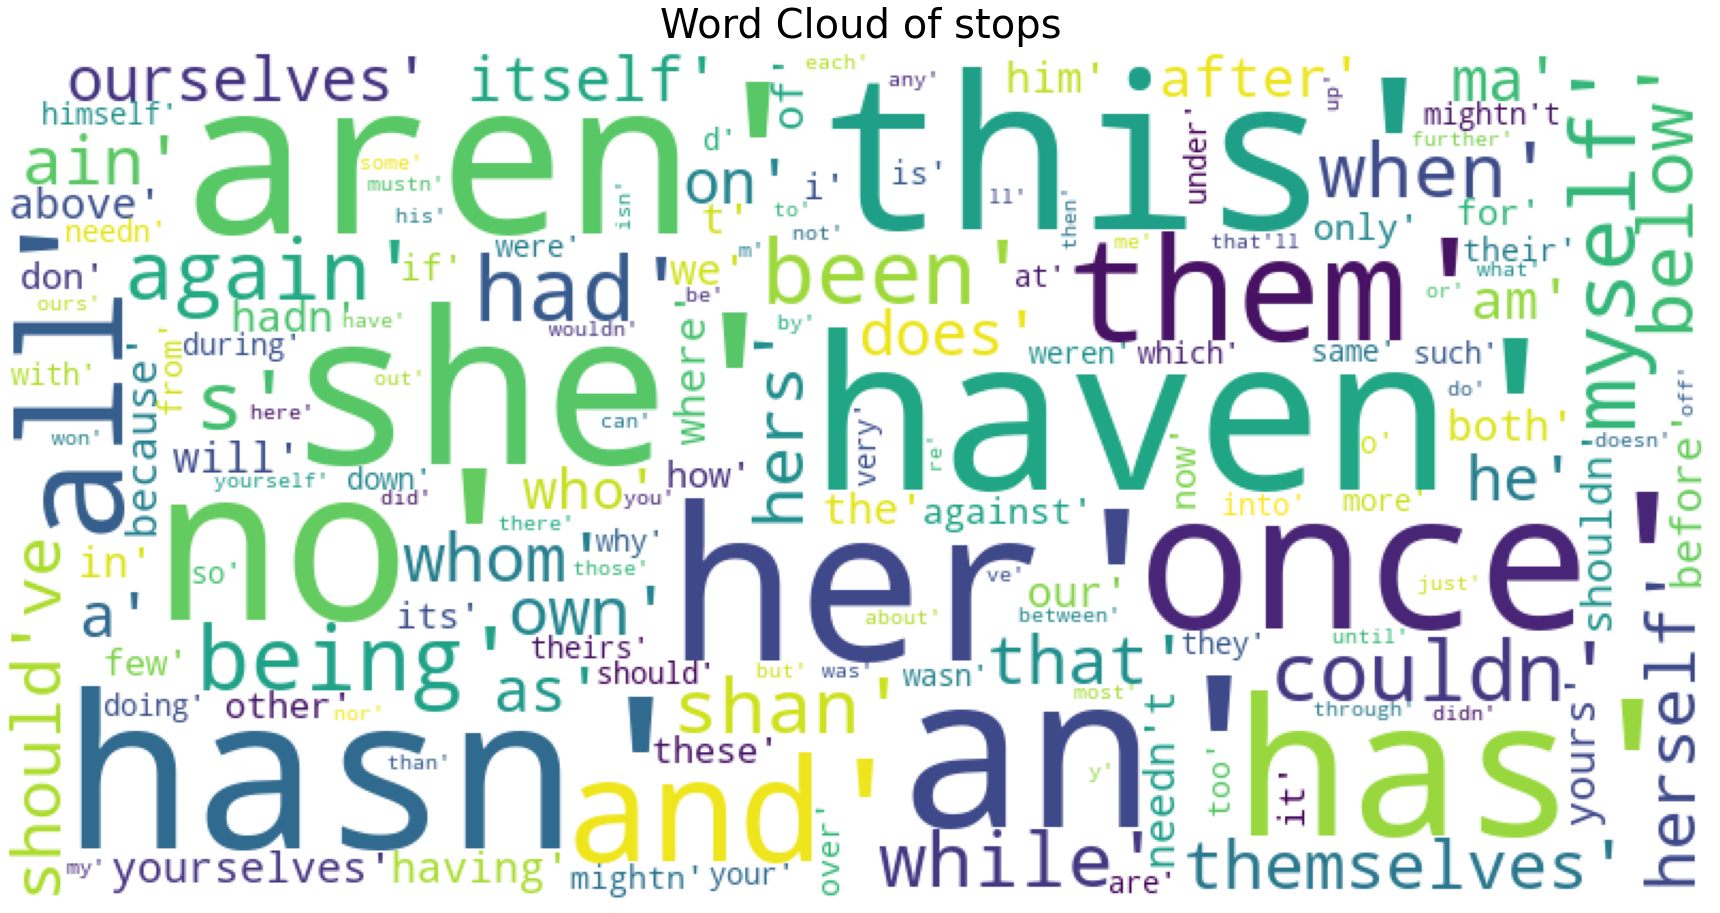

In [35]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',stopwords = stopwords,max_words = max_words,max_font_size = max_font_size,random_state = 42,width=800,height=400,mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stops, title="Word Cloud of stops")


In [36]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [37]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [38]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

CPU times: user 1min 28s, sys: 77.7 ms, total: 1min 28s
Wall time: 1min 28s


In [39]:
df_all['review_clean'][1]

'son halfway fourth week intuniv becam concern began last week start take highest dose two day could hard get bed cranki slept near hour drive home school vacat unusu call doctor monday morn said stick day see school get morn last two day problem free much agreeabl ever less emot good thing less cranki rememb thing overal behavior better tri mani differ medic far effect'

In [40]:
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [41]:
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,no side effect take combin bystol mg fish oil,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv becam concern ...,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,use take anoth oral contracept pill cycl happi...,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time use form birth control glad went pa...,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxon complet turn life around feel healthie...,1


In [42]:
word_table = pd.read_csv("inquirerbasic.csv")

In [43]:
word_table.head()

,Entry,Source,Positiv,Negativ
0,A,H4Lvd,NaN,NaN
1,ABANDON,H4Lvd,NaN,Negativ
2,ABANDONMENT,H4,NaN,Negativ
3,ABATE,H4Lvd,NaN,Negativ
4,ABATEMENT,Lvd,NaN,NaN


In [44]:
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)  #del temp_Positiv

#Negativ word list          
temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)

2006

In [45]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 

In [46]:
len_train = df_train.shape[0]
df_all = pd.concat([df_train,df_test])
del df_train, df_test;
gc.collect()

26046

In [47]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month

In [48]:
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month
130185,66913,Seroquel,Generalized Anxiety Disorde,"""After trying nearly every SSRI on the market ...",9,2010-11-26,102,tri near everi ssri market place pristiq impro...,1,26,2010,11
155501,222222,Fluconazole,"Onychomycosis, Toenail","""This takes 6+ months, but did clear up a deca...",9,2008-05-03,39,take month clear decad long infect,1,3,2008,5
75325,75807,Temazepam,Insomnia,"""Worked for awhile pretty well but then went b...",2,2016-04-21,15,work awhil pretti well went back mayb get hour...,0,21,2016,4
19174,229747,Ketamine,Pain,"""I was given this after surgery for pain as I ...",1,2016-04-16,19,given surgeri pain morphin tri drug sort omg w...,0,16,2016,4
209735,102495,Aripiprazole,Major Depressive Disorde,"""Abilify served me well over a two month perio...",9,2016-12-16,5,abilifi serv well two month period antidepress...,1,16,2016,12


In [49]:

reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment
df_all.head()

100%|██████████| 212053/212053 [00:46<00:00, 4547.27it/s]


,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment
130185,66913,Seroquel,Generalized Anxiety Disorde,"""After trying nearly every SSRI on the market ...",9,2010-11-26,102,tri near everi ssri market place pristiq impro...,1,26,2010,11,0.023958
155501,222222,Fluconazole,"Onychomycosis, Toenail","""This takes 6+ months, but did clear up a deca...",9,2008-05-03,39,take month clear decad long infect,1,3,2008,5,0.025000
75325,75807,Temazepam,Insomnia,"""Worked for awhile pretty well but then went b...",2,2016-04-21,15,work awhil pretti well went back mayb get hour...,0,21,2016,4,-0.125000
19174,229747,Ketamine,Pain,"""I was given this after surgery for pain as I ...",1,2016-04-16,19,given surgeri pain morphin tri drug sort omg w...,0,16,2016,4,0.166667
209735,102495,Aripiprazole,Major Depressive Disorde,"""Abilify served me well over a two month perio...",9,2016-12-16,5,abilifi serv well two month period antidepress...,1,16,2016,12,0.038889


In [50]:
reviews = df_all['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 212053/212053 [01:30<00:00, 2330.63it/s]


In [51]:
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment,Predict_Sentiment2
130185,66913,Seroquel,Generalized Anxiety Disorde,"""After trying nearly every SSRI on the market ...",9,2010-11-26,102,tri near everi ssri market place pristiq impro...,1,26,2010,11,0.023958,0.093750
155501,222222,Fluconazole,"Onychomycosis, Toenail","""This takes 6+ months, but did clear up a deca...",9,2008-05-03,39,take month clear decad long infect,1,3,2008,5,0.025000,0.025000
75325,75807,Temazepam,Insomnia,"""Worked for awhile pretty well but then went b...",2,2016-04-21,15,work awhil pretti well went back mayb get hour...,0,21,2016,4,-0.125000,-0.116667
19174,229747,Ketamine,Pain,"""I was given this after surgery for pain as I ...",1,2016-04-16,19,given surgeri pain morphin tri drug sort omg w...,0,16,2016,4,0.166667,-0.089286
209735,102495,Aripiprazole,Major Depressive Disorde,"""Abilify served me well over a two month perio...",9,2016-12-16,5,abilifi serv well two month period antidepress...,1,16,2016,12,0.038889,-0.029167


In [53]:
import string
df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)
df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))
df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))
df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))
df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))
df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/home/sumit/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [54]:
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment,Predict_Sentiment2,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
130185,66913,Seroquel,Generalized Anxiety Disorde,"""After trying nearly every SSRI on the market ...",9,2010-11-26,102,tri near everi ssri market place pristiq impro...,1,26,2010,11,0.023958,0.093750,1,52,49,314,17,10,16,62,5.057692
155501,222222,Fluconazole,"Onychomycosis, Toenail","""This takes 6+ months, but did clear up a deca...",9,2008-05-03,39,take month clear decad long infect,1,3,2008,5,0.025000,0.025000,1,6,6,34,5,0,1,4,4.833333
75325,75807,Temazepam,Insomnia,"""Worked for awhile pretty well but then went b...",2,2016-04-21,15,work awhil pretti well went back mayb get hour...,0,21,2016,4,-0.125000,-0.116667,1,21,19,121,4,1,2,18,4.809524
19174,229747,Ketamine,Pain,"""I was given this after surgery for pain as I ...",1,2016-04-16,19,given surgeri pain morphin tri drug sort omg w...,0,16,2016,4,0.166667,-0.089286,1,33,29,181,17,9,12,39,4.515152
209735,102495,Aripiprazole,Major Depressive Disorde,"""Abilify served me well over a two month perio...",9,2016-12-16,5,abilifi serv well two month period antidepress...,1,16,2016,12,0.038889,-0.029167,1,60,48,376,12,9,17,62,5.283333


In [55]:
df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

In [56]:
df_train = df_all[:len_train]
df_test = df_all[len_train:]

In [57]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent','count_word', 'count_unique_word', 'count_letters', 'count_punctuations','count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']
sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(n_estimators=10000,learning_rate=0.10,num_leaves=30,subsample=.9,max_depth=7,reg_alpha=.1,reg_lambda=.1,min_split_gain=.01,min_child_weight=2,silent=-1,verbose=-1,)
        
clf.fit(trn_x, trn_y, eval_set= [(trn_x, trn_y), (val_x, val_y)], verbose=100, early_stopping_rounds=100)

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.481279	valid_1's binary_logloss: 0.494978
[200]	training's binary_logloss: 0.464017	valid_1's binary_logloss: 0.489836
[300]	training's binary_logloss: 0.448687	valid_1's binary_logloss: 0.485795
[400]	training's binary_logloss: 0.434477	valid_1's binary_logloss: 0.481708
[500]	training's binary_logloss: 0.422172	valid_1's binary_logloss: 0.478113
[600]	training's binary_logloss: 0.410153	valid_1's binary_logloss: 0.4747
[700]	training's binary_logloss: 0.399379	valid_1's binary_logloss: 0.471887
[800]	training's binary_logloss: 0.388203	valid_1's binary_logloss: 0.468779
[900]	training's binary_logloss: 0.377657	valid_1's binary_logloss: 0.465732
[1000]	training's binary_logloss: 0.367101	valid_1's binary_logloss: 0.462981
[1100]	training's binary_logloss: 0.357608	valid_1's binary_logloss: 0.460332
[1200]	training's binary_logloss: 0.348188	valid_1's binary_logloss: 0.457833
[1300]	traini

In [61]:
y_test = df_test['sentiment']
solution = y_test.copy()
metrics.confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[13698,  7311],
       [ 3664, 45305]])

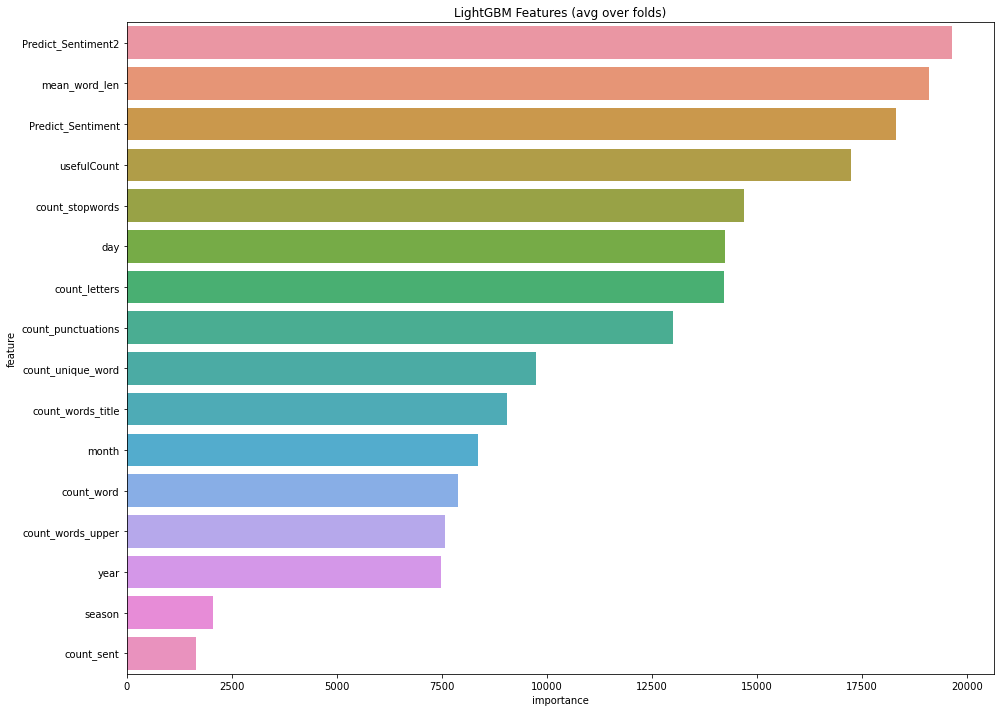

In [62]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [63]:
sub_preds

array([0, 1, 0, ..., 0, 1, 1])

In [64]:
vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

In [65]:
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment,Predict_Sentiment2,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,season,num_Positiv_word,num_Negativ_word,Positiv_ratio,sentiment_by_dic
147354,126702,Brimonidine,Rosacea,"""Never , never , never use this cream !!!!!! I...",1,2015-08-31,17,never never never use cream help way angri dis...,0,31,2015,8,0.116667,-0.157955,1,58,41,335,58,5,11,54,4.793103,2,NaN,NaN,NaN,0.5
195249,84765,Ethinyl estradiol / norgestimate,Birth Control,"""I was switched to this after about 9 months o...",10,2016-05-01,3,switch month mononessa ask switch happen anywa...,1,1,2016,5,-0.257407,-0.210916,1,50,42,314,27,6,14,50,5.300000,1,NaN,NaN,NaN,0.5
86265,71559,Vraylar,Bipolar Disorde,"""I began at 1.5 then titrated to 3mg dosage. A...",3,2016-08-17,17,began titrat mg dosag first love medicin compl...,0,17,2016,8,0.041667,0.139815,1,41,38,251,20,6,9,41,5.146341,2,NaN,NaN,NaN,0.5
44172,132320,Ativan,Anxiety,"""Ativan 0.5mg calms me down considerably withi...",5,2012-01-12,26,ativan mg calm consider within minut side effe...,0,12,2012,1,-0.170530,-0.061481,1,62,54,353,27,7,8,55,4.709677,4,0.0,4.0,0.0,0.0
90569,177278,Duloxetine,Generalized Anxiety Disorde,"""My thoughts on Cymbalta: Cymbalta has left me...",1,2017-05-03,29,thought cymbalta cymbalta left fog no feel non...,0,3,2017,5,0.071429,-0.122253,2,68,61,395,38,12,19,65,4.823529,1,NaN,NaN,NaN,0.5


In [66]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='condition',how='left')
    return data
#___________________________________________________________
df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [68]:
# df_test['deep_pred'] = sub_preds_deep
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']

In [72]:
df_train['sentiment']

130185    1
155501    1
75325     0
19174     0
209735    1
         ..
119879    1
103694    1
131932    1
146867    1
121958    1
Name: sentiment, Length: 142075, dtype: int64